# 루브릭

1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.	
 - 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.	
 - gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.
 - 모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다.




In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## STEP 2. 데이터셋 구성하기

In [31]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [32]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [33]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


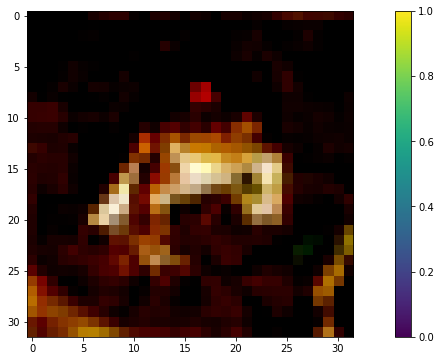

In [34]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

In [35]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성

## STEP 3. 생성자 모델 구현하기

In [38]:
# from tensorflow.keras.layers import GaussianNoise

def make_generator_model():

    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(GaussianNoise(0.2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(layers.Reshape((8, 8, 256)))
#     model.add(GaussianNoise(0.2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(GaussianNoise(0.2))
    model.add(tf.keras.layers.Dropout(0.4))

#     model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(GaussianNoise(0.2))
    model.add(tf.keras.layers.Dropout(0.4))

#     model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
#     model.add(GaussianNoise(0.2))

    return model

In [39]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 256)        

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수

In [40]:
noise = tf.random.normal([1, 100])

In [41]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

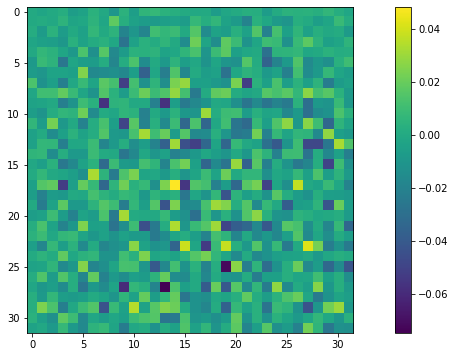

In [42]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기

In [43]:
def make_discriminator_model():

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.AveragePooling2D())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.AveragePooling2D())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

In [44]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 2, 256)        

In [45]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0003675]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기

In [46]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [47]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# loss function을 max log D로 사용
# def generator_loss(fake_output):
#     return -cross_entropy(tf.ones_like(fake_output), fake_output)

In [48]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [49]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [50]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
# discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=4e-4)

In [51]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [52]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [53]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [54]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')   
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [55]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 훈련과정 상세 기능 구현하기

In [56]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [57]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

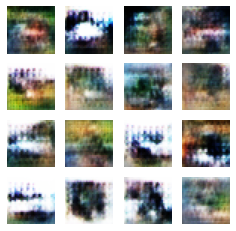

Time for training : 1553 sec


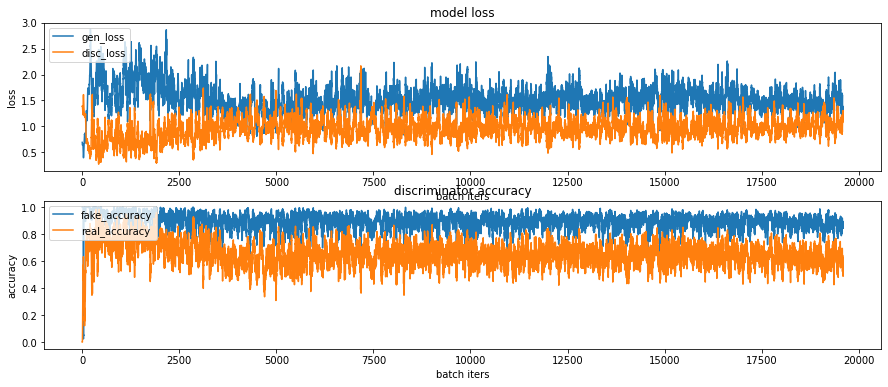

CPU times: user 26min 29s, sys: 2min 48s, total: 29min 17s
Wall time: 25min 54s


In [87]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [88]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 3734828 May  1 03:45 /aiffel/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif


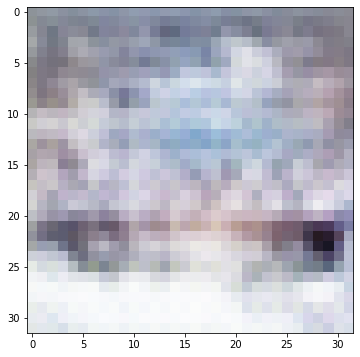

In [59]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

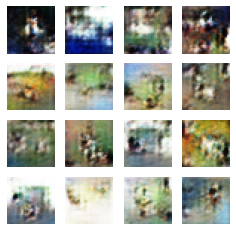

Time for training : 1545 sec


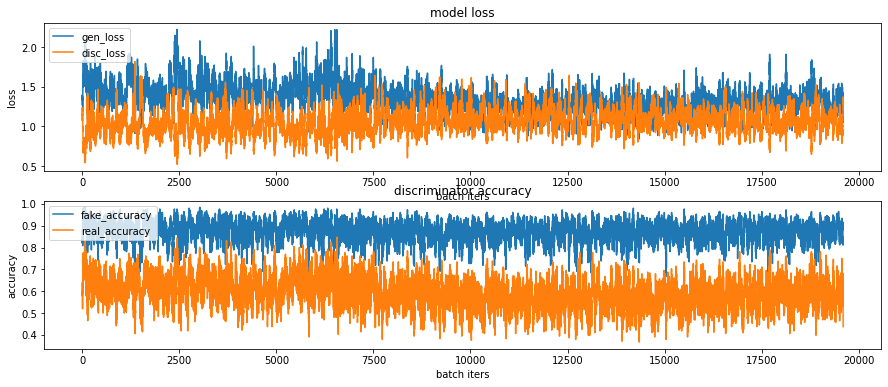

CPU times: user 26min 28s, sys: 2min 47s, total: 29min 16s
Wall time: 25min 46s


In [90]:
# epochs 200
%%time
train(train_dataset, EPOCHS, save_every)

아직 그림이 흐릿하고 accuracy값이 좋지 않다.

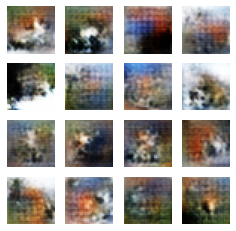

Time for training : 1606 sec


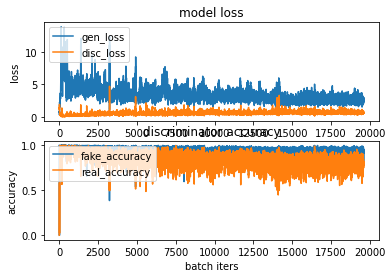

CPU times: user 27min 5s, sys: 2min 44s, total: 29min 49s
Wall time: 26min 47s


In [119]:
# epochs 100
%%time
train(train_dataset, EPOCHS, save_every)

- G에 dropout(0.3)추가
- learning_rate=4e-4로 변경

epochs 100

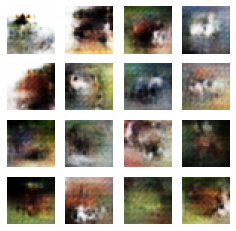

Time for training : 2832 sec


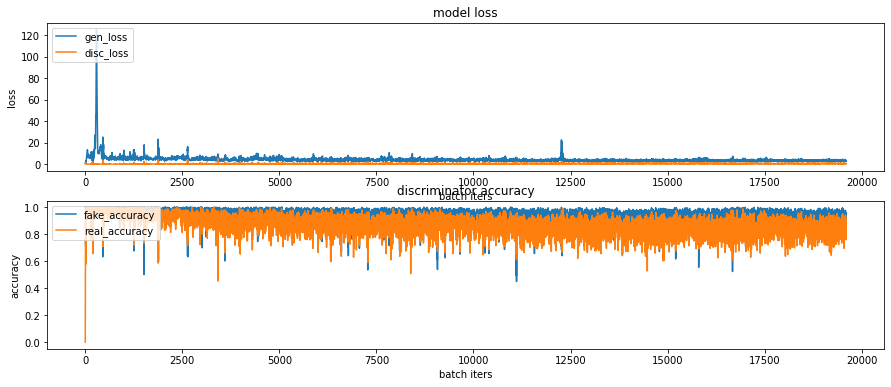

CPU times: user 47min 29s, sys: 2min 43s, total: 50min 12s
Wall time: 47min 14s


In [147]:
%%time
train(train_dataset, EPOCHS, save_every)

- D에 dropout(0.3)
- D Convolutional 레이어의 필터 수 증가 (64,128) -> (128,256)

epochs 100

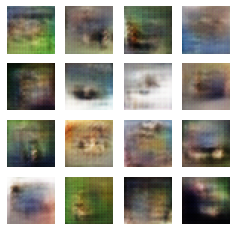

Time for training : 2917 sec


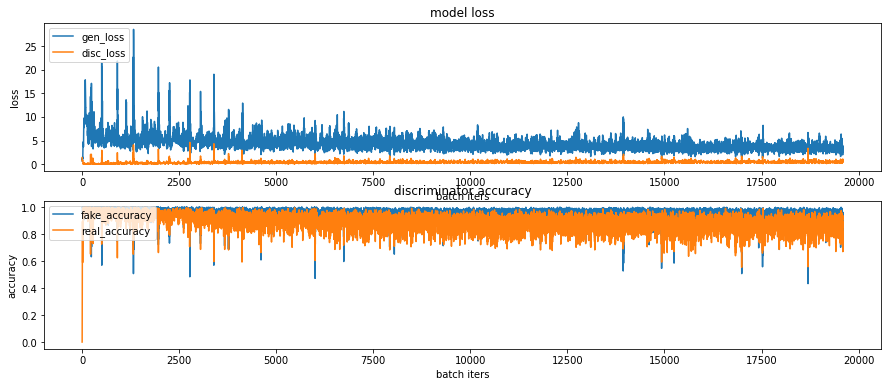

CPU times: user 48min 34s, sys: 2min 44s, total: 51min 19s
Wall time: 48min 39s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

epochs 200

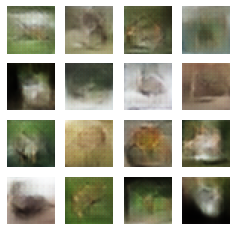

Time for training : 2913 sec


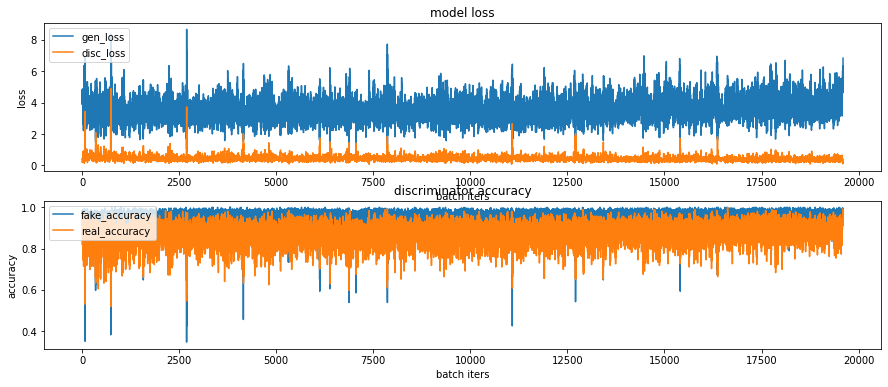

CPU times: user 48min 47s, sys: 2min 43s, total: 51min 31s
Wall time: 48min 35s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)를 참고하여 G에 dropout을 0.5로 변경
- fake_accuracy와 real_accuracy가 비슷한데 0.5와 가깝지는 않다.
- 분산은 작아 보이지만 원하는 수치가 아니다

epochs 100

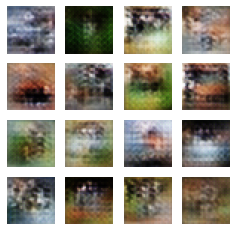

Time for training : 2879 sec


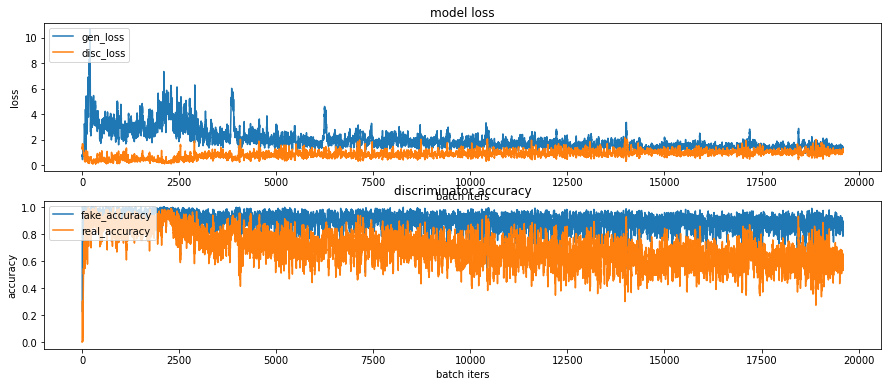

CPU times: user 48min 18s, sys: 2min 44s, total: 51min 2s
Wall time: 48min 1s


In [58]:
%%time
train(train_dataset, EPOCHS, save_every)

epochs 200

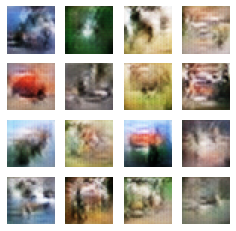

Time for training : 2884 sec


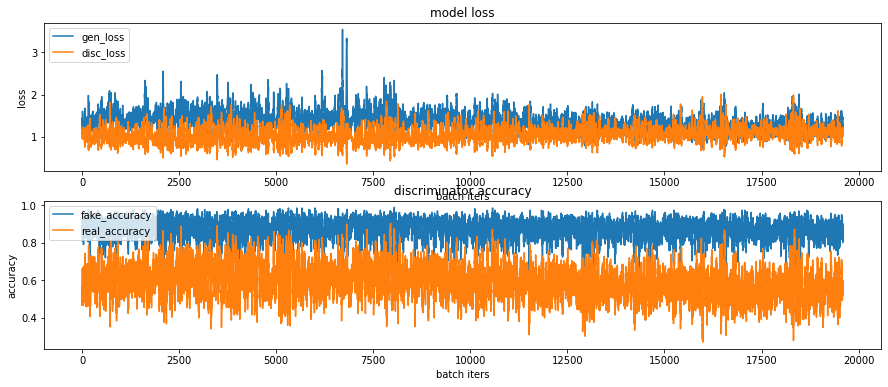

CPU times: user 48min 22s, sys: 2min 44s, total: 51min 7s
Wall time: 48min 5s


In [60]:
%%time
train(train_dataset, EPOCHS, save_every)

G Convolutional 레이어의 필터 수 증가 (64,128) -> (128,256)<br/>
G Convolutional 레이어의 Dropout 0.5 -> 0.4

- real_accuracy의 경우 0.5~0.6 부근에 위치하고 있는 것을 확인
- fake_accuracy의 경우 전의 하이퍼파라미터 값때 보다는 수치가 내려왔지만 여전히 목표치에는 못미침

# 회고

- 주로 [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)를 참고하며 학습하였는데 loss function을 max log D로 사용하거나 discriminator에 SGD를 사용하면 학습이 원활히 진행 되지 않았다. 다른 부분에서 잘못이 있었을 것 같아 추가적으로 봐야할 것 같다.
- 시간이 부족하여 여러 방법을 사용하여 학습을 시켜보지 못한 점이 아쉽다.
- 처음으로 GAN(DCGAN)을 사용하여 학습을 진행하여 보았는데 discriminator, generator와 같은 개념을 새로 배웠으며 따로 모델을 만들어 학습시킨다는 것을 실습해보았다.
- 생각보다 원하는 수치가 나오지 않음에 아쉬웠고 더 많은 방법론이 있는듯 하다.